# Import Necessary Librires 

In [1]:
import pandas as pd
import numpy as np
import  mlflow.sklearn
import matplotlib.pyplot as plt
import mlflow, argparse, joblib, warnings, itertools, pickle
# For Runtime Measurement
import time, timeit
# For Memory Usage
import psutil
warnings.filterwarnings('ignore')

# metrix,
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, accuracy_score, f1_score

#Algorithms
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from scipy.stats import randint
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import xgboost as xgb

#Models
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score

# Loading Data

In [2]:
df = pd.read_parquet(r"../../data/V6_ReduceDimension_Data.parquet")
df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,taxi_demand
0,7232.423961,1.917840,3.593047,-1.520966,1.378757,1.594858,-0.398472,-0.214360,-2.450065,-0.298501,-2.372837,0.853763,-1.258673,-0.016103,-2.541717e-15,-4.228377e-14,1.265271e-17,9.903077e-21,-6.415206e-32,-0.086022
1,8450.424030,2.242227,3.789262,-0.164432,1.304658,0.776806,-0.565016,0.171054,-2.796305,-0.094508,-2.241521,1.258338,0.361904,0.040717,5.565055e-13,-2.290931e-16,-2.459113e-16,3.465575e-21,2.819584e-30,-0.086022
2,7568.423905,2.921402,3.676932,0.123669,1.305928,0.252489,-0.408997,0.327325,-2.931228,-0.347989,-2.125539,1.834953,0.778209,0.013537,-7.894685e-16,9.182485e-14,4.328383e-17,1.672041e-20,-5.235990e-31,-0.086022
3,9988.423917,4.125735,3.488578,0.979430,1.287473,-0.610574,-0.368645,0.694405,-3.199143,-0.312189,-1.877975,3.015216,1.453752,-0.073135,-2.309535e-15,1.066815e-13,-4.836991e-18,-1.045812e-19,-4.348663e-31,-0.086022
4,11093.423843,5.250869,3.348828,1.852266,1.265425,-1.525679,-0.294683,1.056983,-3.481290,-0.309485,-1.655867,4.082340,2.310911,-0.079123,1.132270e-15,1.138803e-14,4.044429e-17,-7.080540e-19,-2.756465e-30,-0.086022


In [3]:
df.shape

(8713, 20)

In [4]:
# splitig
X = df.drop(columns= ["taxi_demand",])
y = df.taxi_demand

In [5]:
# Load and preprocess your data (X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

In [6]:
X_train.shape, X_test.shape

((6970, 19), (1743, 19))

In [7]:
y_train.shape, y_test.shape

((6970,), (1743,))

# Experiment Tracking:

In [8]:
mlflow.set_experiment("TimeSeries")

2023/12/23 10:50:55 INFO mlflow.tracking.fluent: Experiment with name 'TimeSeries' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///C:/Users/SRA/Desktop/backup/C/MLgrit/time_series_project/uber-taxi-demand/notebooks/c_Model/mlruns/575847369339992197', creation_time=1703307055698, experiment_id='575847369339992197', last_update_time=1703307055698, lifecycle_stage='active', name='TimeSeries', tags={}>

- Model Training and Logging:

# LinearRegression

In [9]:
lr_reg=LinearRegression()
parameters = {'fit_intercept':[True,False], 'copy_X':[True, False]}
grid = GridSearchCV(lr_reg,parameters, cv=None)
grid.fit(X_train, y_train)
print(grid.best_estimator_)
print(grid.best_params_)
y_pred = grid.best_estimator_.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"r2_score: {r2}")

LinearRegression()
{'copy_X': True, 'fit_intercept': True}
r2_score: 0.15825350608491262


# RandomForestRegressor

In [10]:
# RandomForestRegressor?

In [11]:
# For Runtime Measurement
start_time = time.time()
# For Memory Usage
def memory_usage():
    process = psutil.Process()
    mem = process.memory_info().rss
    return mem / (1024 * 1024)  # Convert to megabytes
    
mlflow.set_experiment('TimeSeries')

with mlflow.start_run():

    model = RandomForestRegressor()
        
    param_dist = {
    'n_estimators': [35, 40, 45],
    # 'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    'max_depth': [3, None],
    'min_samples_split': randint(2, 11),  # Define the range for min_samples_split
    'min_samples_leaf': randint(1, 11),   # Define the range for min_samples_leaf
    'max_features': ['sqrt', 'log2'],
    }
    
    # Run randomized search
    n_iter_search = 20
    random_search = RandomizedSearchCV(model, param_distributions = param_dist, n_iter = n_iter_search)
    # fit the data
    random_search.fit(X_train, y_train)
    # test the data
    y_pred = random_search.best_estimator_.predict(X_test)
    # Log parameters
    mlflow.log_params(random_search.best_params_)
    
    
    # Calculate and log the evaluation metric (e.g., RMSE)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(" ",end='\n')
    print(f"mean_squared_error: {rmse}")
    print(f"mean_absolute_percentage_error: {mape}")
    print(f"mean_absolute_error: {mae}")
    print(f"r2_score: {r2}")
    print(" ",end='\n')
    print(random_search.best_params_)
    print(" ",end='\n')

    
    mlflow.log_metrics({
        "RMSE": rmse,
        "MAE": mae,
        "MAPE0": mape,
        "R2_SCORE": r2
    })
    
    # Log the best model using MLflow
    mlflow.sklearn.log_model(model, 'RandomForestRegressor')
    
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")
print(" ",end='\n')
print(f"Memory usage: {memory_usage()} megabytes")

 
mean_squared_error: 0.3143904836301717
mean_absolute_percentage_error: 0.07854527203296816
mean_absolute_error: 0.02002868470443854
r2_score: 0.8422553878167158
 
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 35}
 
Elapsed time: 68.90310549736023 seconds
 
Memory usage: 306.421875 megabytes


# KNeighborsRegressor

In [12]:
# KNeighborsRegressor?

In [13]:
# For Runtime Measurement
start_time = time.time()
# For Memory Usage
def memory_usage():
    process = psutil.Process()
    mem = process.memory_info().rss
    return mem / (1024 * 1024)  # Convert to megabytes
    
mlflow.set_experiment("TimeSeries")

with mlflow.start_run():
    model = KNeighborsRegressor() 
    
    param_grid = {
        "n_neighbors" : [1],
        "weights": ['uniform', 'distance'], # uniform gives equal or same priority for each vote, distance gives more priority for the closer vote.   
        "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],
        "leaf_size": [30],
        "p": [2],
        "metric": ['minkowski'],
        "metric_params": [None],
        "n_jobs": [None],
    }
    # GridSearchCV Each combination will try.
    # RandomizedSearchCV Some random combination will try and we use it for huge data processing.
    grid = GridSearchCV(model, param_grid = param_grid, scoring="neg_mean_squared_error", cv=5)
    
    grid.fit(X_train, y_train)
    
    # Log parameters
    mlflow.log_params(grid.best_params_)
    
    # Predict on the test set using the best estimator from the grid search
    y_pred = grid.best_estimator_.predict(X_test)
    
    # Calculate and log the evaluation metric (e.g., RMSE)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(" ",end='\n')
    print(f"mean_squared_error: {rmse}")
    print(f"mean_absolute_percentage_error: {mape}")
    print(f"mean_absolute_error: {mae}")
    print(f"r2_score: {r2}")
    print(" ",end='\n')
    print(grid.best_params_)
    print(" ",end='\n')
    
    mlflow.log_metrics({
        "RMSE": rmse,
        "MAE": mae,
        "MAPE0": mape,
        "R2_SCORE": r2
    })
    
    # Log the best model using MLflow
    mlflow.sklearn.log_model(model, 'knn')

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Run time: {elapsed_time} seconds")
print(" ",end='\n')
print(f"Memory usage: {memory_usage()} megabytes")

 
mean_squared_error: 0.2805085381733931
mean_absolute_percentage_error: 0.0005779688464642641
mean_absolute_error: 0.00671888784014707
r2_score: 0.8744236311239193
 
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}
 
Run time: 8.60001254081726 seconds
 
Memory usage: 311.00390625 megabytes


In [14]:
score = []

for i in range(1, 16):
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    score.append(r2_score(y_test, y_pred))

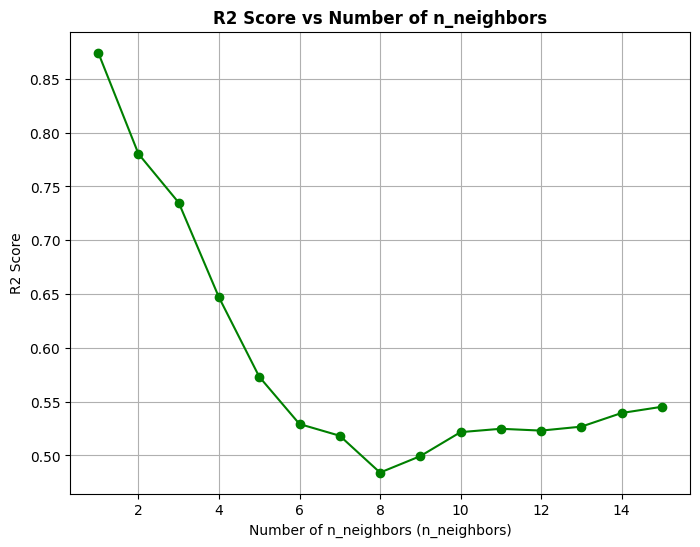

In [15]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, 16), score, marker='o', color="green")  # Plotting n_neighbors vs R2 score
plt.title('R2 Score vs Number of n_neighbors', weight="bold")
plt.xlabel('Number of n_neighbors (n_neighbors)')
plt.ylabel('R2 Score')
plt.grid(True)
plt.show()

# Bagging Ensemble 

In [16]:
knn = KNeighborsRegressor(n_neighbors=1)  

# Initialize BaggingRegressor with KNN as the base estimator
bagging_knn = BaggingRegressor(base_estimator=knn, n_estimators=10, random_state=33)

# Fit the BaggingRegressor on the training data
bagging_knn.fit(X_train, y_train)

# Make predictions
predictions = bagging_knn.predict(X_test)

# Evaluate the performance
r2 = r2_score(y_test, predictions)
print(f"R2 Score: {r2}")


R2 Score: 0.8091239193083574


In [17]:
from sklearn.tree import DecisionTreeRegressor
knn = KNeighborsRegressor()
linear = LinearRegression()
dec = DecisionTreeRegressor()

params = {
    'base_estimator': [None, knn, linear, dec],  # Changed 'base_estimators' to 'base_estimator'
    'n_estimators': [20, 50, 100],
    'max_samples': [0.5, 1.0],
    'max_features': [0.5, 1.0],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False],
}


# Initialize BaggingRegressor with KNN as the base estimator
bagging = GridSearchCV(BaggingRegressor(random_state=1, n_jobs=1), param_grid=params, cv=3, n_jobs=1, verbose=1)

# Fit the BaggingRegressor on the training data
bagging.fit(X_train, y_train)

# Make predictions
predictions = bagging.predict(X_test)

# Evaluate the performance
r2 = r2_score(y_test, predictions)
print(f"R2 Score: {r2}")

# Predict on the training data
train_predictions = bagging.predict(X_train)

# Evaluate the performance on training data
train_r2 = r2_score(y_train, train_predictions)
print(f"Training R2 Score: {train_r2}")

print("", end='\n')
print(bagging.best_params_)


Fitting 3 folds for each of 192 candidates, totalling 576 fits
R2 Score: 0.8703549567723343
Training R2 Score: 1.0

{'base_estimator': None, 'bootstrap': False, 'bootstrap_features': True, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 50}


# XGBoost

In [18]:
# XGBRFRegressor?

In [19]:
# For Runtime Measurement
start_time = time.time()
# For Memory Usage
def memory_usage():
    process = psutil.Process()
    mem = process.memory_info().rss
    return mem / (1024 * 1024)  # Convert to megabytes
    
mlflow.set_experiment("TimeSeries")

with mlflow.start_run():
    x_model = xgb.XGBRFRegressor()

    param_dist = {
        'max_depth':  [3, 4,5],
        'n_estimators': randint(100,600),
        'min_child_weight': [3, 4,5,6],
        'gamma':[0,0.1,0.2],
        'colsample_bytree':[0.7,0.8,0.9],
        'nthread': [3,4,5],
    }

    # run a randomized search
    n_iter_search = 20
    random_search = RandomizedSearchCV(x_model, param_distributions = param_dist, n_iter = n_iter_search)
    # fit the model
    random_search.fit(X_train, y_train)
    # Predict on the test set using the best estimator from the grid search
    y_pred = random_search.best_estimator_.predict(X_test)
    # Log parameters
    mlflow.log_params(random_search.best_params_)
    
    # Calculate and log the evaluation metric (e.g., RMSE)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(" ",end='\n')
    print(f"mean_squared_error: {rmse}")
    print(f"mean_absolute_percentage_error: {mape}")
    print(f"mean_absolute_error: {mae}")
    print(f"r2_score: {r2}")
    print(" ",end='\n')
    print(random_search.best_params_)
    print(" ",end='\n')

    #Log Matrics
    mlflow.log_metrics({
        "RMSE": rmse,
        "MAE": mae,
        "MAPE0": mape,
        "R2_SCORE": r2
    })
        
    # # Log the best model using MLflow
    mlflow.sklearn.log_model(x_model, 'XGBRFRegressor')

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Run time: {elapsed_time} seconds")
print(" ",end='\n')
print(f"Memory usage: {memory_usage()} megabytes")

 
mean_squared_error: 0.32692076225178224
mean_absolute_percentage_error: 0.06835326479518834
mean_absolute_error: 0.018412402707316786
r2_score: 0.8294307433305648
 
{'colsample_bytree': 0.7, 'gamma': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 589, 'nthread': 3}
 
Run time: 80.51959824562073 seconds
 
Memory usage: 330.3203125 megabytes
